# Clique Cover問題
グラフ$G=(V,E)$が与えられたとき、そのグラフをいくつかの部分グラフに分割する(別々の色$i = 1, \dots ,n$ に塗り分ける)ことを考えます。このときそれぞれの部分グラフがクリーク(その部分グラフだけに注目したとき完全グラフとなっているもの)となるような分割の仕方を求める問題をclique cover問題といいます。

# ハミルトニアン
頂点$v$を色$i$で塗り分けるかどうかを$x_{v,i}$と表すことにします。clique cover問題のハミルトニアン表現は以下のようになります

$ \displaystyle H = A \sum_v \left( 1 - \sum_{i = 1}^n x_{v,i} \right)^2 + B \sum_{i=1}^n \left[ \frac {1}{2} \left( -1 + \sum_v x_{v,i} \right) \sum_v x_{v,i} - \sum_{(uv) \in E} x_{u,i}x_{v.i} \right]$

$H$の第一項は各頂点$v$について、ただ一つの色で塗られているとき最小値0をとります。
次に第二項を見ていきます。$\displaystyle \frac {1}{2} \left( -1 + \sum_v x_{v,i} \right) \sum_v x_{v,i}$の部分は色$i$で塗られている頂点の数$\displaystyle \sum_v x_{v,i}$を$n_i$と書くと、$ {}_{n_i} C _2$と一致します。つまり全ての頂点から二つの頂点を選ぶ組み合わせとなります。これは色$i$で塗られた頂点からなる完全グラフの辺の数と一致します。後半の$\displaystyle \sum_{(uv) \in E} x_{u,i}x_{v.i}$の部分は色$i$で塗られている部分グラフに含まれる実際の辺の数を表しています。これはその部分グラフが完全グラフだった場合に限り、前者の値($ {}_{n_i} C _2$)と同じになるので、第二項は問題の条件通りクリークで分割できている場合のみ最小値0を取ります。QUBO行列を計算するために以下のように式変形しておきます。

$ \displaystyle H = A \sum_v \left\{ -2 \sum_{i=1}^n x_{v,i} + \left(\sum_{i=1}^n x_{v,i}\right)^2 \right\} + B \sum_{i=1}^n \left\{ -\frac{1}{2} \sum_v x_{v,i} + \frac{1}{2}\left( \sum_v x_{v,i}\right)^2 - \sum_{(u,v) \in E} x_{u,i}x_{v,i}\right\}+ Const. $  
$ \displaystyle = A \sum_v \left( -2 \sum_{i=1}^n x_{v,i} + \sum_{i=1}^n x_{v,i}^2 + 2\mathop{ \sum \sum }_{i \neq j }^{n} x_{v,i}x_{v,j} \right) + B \sum_{i=1}^n \left\{ \frac{1}{2} \left(-\sum_v x_{v,i} + \sum_v x_{v,i}^2 + \mathop{\sum \sum}_{u \neq v}^{n} x_{u,i}x_{v,i} \right) - \sum_{(u,v) \in E} x_{u,i}x_{v,i}\right\}+ Const. $  
$ \displaystyle = A \sum_v \left( - \sum_{i=1}^n x_{v,i}^2 + 2\mathop { \sum \sum }_{i \neq j }^{n} x_{v,i}x_{v,j} \right) + B \sum_{i=1}^n \left( \frac{1}{2} \mathop{\sum \sum}_{u \neq v}^{n}x_{u,i}x_{v,i} - \sum_{(u,v) \in E} x_{u,i}x_{v,i}\right)+ Const. $

# QUBOを計算して問題を解く
QUBOを計算する関数と答えを表示する関数を用意します。

In [59]:
import numpy as np

def get_qubo(adjacency_matrix, n_color, A, B):
    graph_size = len(adjacency_matrix)
    qubo_size = graph_size * n_color
    qubo = np.zeros((qubo_size, qubo_size))
    indices = [(u,v,i,j) for u in range(graph_size) for v in range(graph_size) for i in range(n_color) for j in range(n_color)]
    for u,v,i,j in indices:
        ui = u * n_color + i
        vj = v * n_color + j
        if ui > vj:
            continue
            
        if ui == vj:
            qubo[ui][vj] -= A
        if u == v and i != j:
            qubo[ui][vj] += A * 2
        if u != v and i == j:
            qubo[ui][vj] += B * 0.5
            if adjacency_matrix[u][v] > 0:
                qubo[ui][vj] -= B
    return qubo

In [60]:
def show_answer(q, graph_size, n_color):
    print(q)
    arr = []
    for v in range(graph_size):
        color = []
        for i in range(n_color):
            index = v * n_color + i
            if q[index] > 0:
                color.append(i)
        print(f"vertex{v}'s color is {color}")
        arr.append(color)
    return arr

In [61]:
def calculate_H(q, adjacency_matrix, n_color, A, B):
    graph_size = len(adjacency_matrix)
    h_a = calculate_H_A(q, graph_size, n_color, A)
    h_b = calculate_H_B(q, adjacency_matrix, n_color, B)
    print(f"H = {h_a + h_b}")
    return h_a + h_b

def calculate_H_A(q, graph_size, n_color, A):
    hamiltonian = 0
    for v in range(graph_size):
        sum_x = 0
        for i in range(n_color):
            index = v * n_color + i
            sum_x += q[index]
        hamiltonian += (1 - sum_x) ** 2
    hamiltonian *= A
    print(f"H_A = {hamiltonian}")
    return hamiltonian

def calculate_H_B(q, adjacency_matrix, n_color, B):
    graph_size = len(adjacency_matrix)
    hamiltonian = 0
    for i in range(n_color):
        sum_x = 0
        for v in range(graph_size):
            vi = v * n_color + i
            sum_x += q[vi]
            for u in range(graph_size):
                if u >= v:
                    continue
                ui = u * n_color + i
                hamiltonian -= adjacency_matrix[u][v] * q[ui] * q[vi]
        hamiltonian += 0.5 * (-1 + sum_x) * sum_x
    hamiltonian *= B
    print(f"H_B = {hamiltonian}")
    return hamiltonian

問題設定を書いて解きます。今回解くグラフは下の図の通りです。  

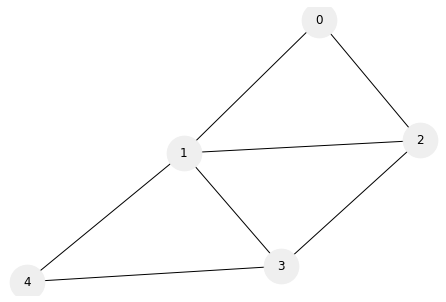

In [62]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

G = nx.Graph()
G.add_edges_from([(0,1),(0,2),(1,2),(1,3),(1,4),(2,3),(3,4)])
nx.draw(G, **options)

データは隣接行列の形で与えます。ハミルトニアンの各項(係数 A,B のかかった項)は常に正または0の値を取るため、 A,B のバランスはそれほど気をつける必要はないと思います。今回は0.1で揃えておきます。

In [63]:
adjacency_matrix = \
[ \
    [0,1,1,0,0], \
    [1,0,1,1,1], \
    [1,1,0,1,0], \
    [0,1,1,0,1], \
    [0,1,0,1,0], \
]

n_color = 2
A = 0.1
B = 0.1

In [64]:
import blueqat.wq as wq
from blueqat import vqe

qubo = get_qubo(adjacency_matrix, n_color, A, B)
result = vqe.Vqe(vqe.QaoaAnsatz(wq.pauli(qubo), step=4)).run()
answer = result.most_common(12)
print(answer)

(((0, 1, 0, 1, 0, 1, 1, 0, 1, 0), 0.03300339421700338), ((1, 0, 1, 0, 1, 0, 0, 1, 0, 1), 0.03300339421700337), ((0, 1, 1, 0, 0, 1, 1, 0, 1, 0), 0.033003394217003365), ((1, 0, 0, 1, 1, 0, 0, 1, 0, 1), 0.033003394217003365), ((1, 0, 1, 0, 1, 0, 1, 0, 1, 0), 0.0329922474049749), ((0, 1, 0, 1, 0, 1, 0, 1, 0, 1), 0.0329922474049749), ((1, 0, 1, 0, 1, 0, 1, 0, 0, 1), 0.032919482754343955), ((0, 1, 1, 0, 1, 0, 1, 0, 1, 0), 0.03291948275434395), ((1, 0, 0, 1, 0, 1, 0, 1, 0, 1), 0.03291948275434395), ((0, 1, 0, 1, 0, 1, 0, 1, 1, 0), 0.032919482754343934), ((0, 1, 1, 1, 0, 1, 1, 0, 1, 0), 0.017442288481315057), ((1, 0, 1, 1, 1, 0, 0, 1, 0, 1), 0.017442288481315057))


計算結果を表示してみます。

In [65]:
for i in range(10):
    calculate_H(answer[i][0], adjacency_matrix, n_color, A, B)
    ans = show_answer(answer[i][0], len(adjacency_matrix), n_color)
    print()

H_A = 0.0
H_B = 0.0
H = 0.0
(0, 1, 0, 1, 0, 1, 1, 0, 1, 0)
vertex0's color is [1]
vertex1's color is [1]
vertex2's color is [1]
vertex3's color is [0]
vertex4's color is [0]

H_A = 0.0
H_B = 0.0
H = 0.0
(1, 0, 1, 0, 1, 0, 0, 1, 0, 1)
vertex0's color is [0]
vertex1's color is [0]
vertex2's color is [0]
vertex3's color is [1]
vertex4's color is [1]

H_A = 0.0
H_B = 0.0
H = 0.0
(0, 1, 1, 0, 0, 1, 1, 0, 1, 0)
vertex0's color is [1]
vertex1's color is [0]
vertex2's color is [1]
vertex3's color is [0]
vertex4's color is [0]

H_A = 0.0
H_B = 0.0
H = 0.0
(1, 0, 0, 1, 1, 0, 0, 1, 0, 1)
vertex0's color is [0]
vertex1's color is [1]
vertex2's color is [0]
vertex3's color is [1]
vertex4's color is [1]

H_A = 0.0
H_B = 0.30000000000000004
H = 0.30000000000000004
(1, 0, 1, 0, 1, 0, 1, 0, 1, 0)
vertex0's color is [0]
vertex1's color is [0]
vertex2's color is [0]
vertex3's color is [0]
vertex4's color is [0]

H_A = 0.0
H_B = 0.30000000000000004
H = 0.30000000000000004
(0, 1, 0, 1, 0, 1, 0, 1, 0, 1)
ve

$H = 0$となっている解が最適解です。